In [37]:
import pandas as pd
from datetime import datetime
import hvplot.pandas  # Ensure hvplot is installed
from IPython.display import HTML
from prophet import Prophet

# Load the data without parsing the dates
search_data = pd.read_csv('Resources/google_hourly_search_trends.csv', index_col='Date')

# Convert the 'Date' column to datetime
search_data.index = pd.to_datetime(search_data.index, format='%m/%d/%y %H:%M')

# Slice the data for May 2020
may_2020_data = search_data.loc['2020-05']

# Visualize the data for May 2020
may_2020_data['Search Trends'].hvplot(title="Google Search Trends in May 2020")

:Curve   [Date]   (Search Trends)

In [38]:
# Group by day of the week and calculate the mean search trends
avg_traffic_by_dow = search_data.groupby(search_data.index.dayofweek).mean()

# Plotting using hvPlot
avg_traffic_by_dow.hvplot(kind='bar', title='Average Search Traffic by Day of the Week', xlabel='Day of the Week', ylabel='Average Search Trends')


:Bars   [Date]   (Search Trends)

In [39]:
# Group the data by hour and day of the week, then calculate the mean search trends
grouped = search_data.groupby([search_data.index.hour, search_data.index.dayofweek])['Search Trends'].mean()

# Create a DataFrame from the grouped Series without directly resetting the index
# This approach avoids potential conflicts with index names
traffic_heatmap_data_df = pd.DataFrame(grouped).rename_axis(['Hour', 'DayOfWeek']).reset_index()

# The DataFrame should now have three columns: 'Hour', 'DayOfWeek', and 'Search Trends'
# Confirm the structure
print(traffic_heatmap_data_df.head())

# Plotting the heatmap
heatmap_plot = traffic_heatmap_data_df.hvplot.heatmap(
    x='Hour',
    y='DayOfWeek',
    C='Search Trends',
    cmap='viridis',
    title='Search Traffic Heatmap by Day of Week and Hour'
).opts(invert_yaxis=True, xlabel='Hour of Day', ylabel='Day of Week', colorbar=True)

# Display the heatmap
heatmap_plot

   Hour  DayOfWeek  Search Trends
0     0          0      86.923077
1     0          1      94.900452
2     0          2      92.450450
3     0          3      91.393665
4     0          4      89.787330


:HeatMap   [Hour,DayOfWeek]   (Search Trends)

In [40]:
# Read in stock price data from the Resources folder, correctly using 'date' for parse_dates and as the index_col
stock_price_data_df = pd.read_csv('Resources/mercado_stock_price.csv', parse_dates=['date'], index_col='date')

# Concatenate search data and stock price data along columns
combined_data_df = pd.concat([search_data, stock_price_data_df], axis=1)

# Filter data for the first half of 2020
first_half_2020_df = combined_data_df.loc['2020-01-01':'2020-06-30']

# Plot search trends and stock closing price using the 'close' column for stock prices
plot = first_half_2020_df.hvplot(y=['Search Trends', 'close'], width=800, height=400, title='Search Trends vs. Stock Price in First Half of 2020').opts(ylabel='Normalized Values', xlabel='Date')

# Display the plot
plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [41]:
# Create 'Lagged Search Trends' by shifting the search trends data by one hour
combined_data_df['Lagged Search Trends'] = combined_data_df['Search Trends'].shift(1)

# Calculate 'Stock Volatility' as the exponentially weighted moving average (EWMA) of the stock's price changes
# The 'span' parameter defines the "lookback" period for calculating the EWMA, here assumed to be 4 hours for "four-hour rolling average"
combined_data_df['Stock Volatility'] = combined_data_df['close'].pct_change().ewm(span=4).std()

# Create 'Hourly Stock Return' as the percentage change in stock price on an hourly basis
combined_data_df['Hourly Stock Return'] = combined_data_df['close'].pct_change()

C:\Users\jan\AppData\Local\Temp\ipykernel_4472\1071775326.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  combined_data_df['Stock Volatility'] = combined_data_df['close'].pct_change().ewm(span=4).std()
C:\Users\jan\AppData\Local\Temp\ipykernel_4472\1071775326.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  combined_data_df['Hourly Stock Return'] = combined_data_df['close'].pct_change()


In [42]:
# Calculate the correlation matrix
correlation_matrix = combined_data_df[['Lagged Search Trends', 'Stock Volatility', 'Hourly Stock Return']].corr()

# Display the correlation matrix
print(correlation_matrix)

                      Lagged Search Trends  Stock Volatility  \
Lagged Search Trends              1.000000         -0.198546   
Stock Volatility                 -0.198546          1.000000   
Hourly Stock Return              -0.018009          0.062424   

                      Hourly Stock Return  
Lagged Search Trends            -0.018009  
Stock Volatility                 0.062424  
Hourly Stock Return              1.000000  


In [43]:
HTML("""
<div>
    <p><strong>Analysis of Correlation:</strong></p>
    <p>Upon calculating the correlation matrix between <em>Lagged Search Trends</em>, <em>Stock Volatility</em>, and <em>Hourly Stock Return</em>, we aim to understand the relationships between these variables. The key insights are as follows:</p>
    <ul>
        <li>A significant <strong>positive correlation</strong> between <em>Lagged Search Trends</em> and <em>Stock Volatility</em> would indicate that as search trends increase or decrease, stock volatility moves in the same direction.</li>
        <li>A significant <strong>negative correlation</strong> suggests that an increase in search trends is associated with a decrease in stock volatility, or vice versa.</li>
        <li>For <em>Hourly Stock Return</em>, a similar interpretation applies, where the direction of the correlation indicates the direction of the relationship with <em>Lagged Search Trends</em>.</li>
    </ul>
    <p>In summary, if the correlation values are close to 1 or -1, it suggests a strong relationship between search trends and stock performance metrics. However, it's crucial to remember that correlation does not imply causation. High or low correlation values indicate areas for further investigation but do not conclusively establish a direct cause-and-effect relationship.</p>
</div>
""")

In [44]:
# Prepare the data
prophet_data_df = search_data.reset_index().rename(columns={'Date': 'ds', 'Search Trends': 'y'})

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(prophet_data_df)

16:03:24 - cmdstanpy - INFO - Chain [1] start processing
16:03:34 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\jan\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\jan\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


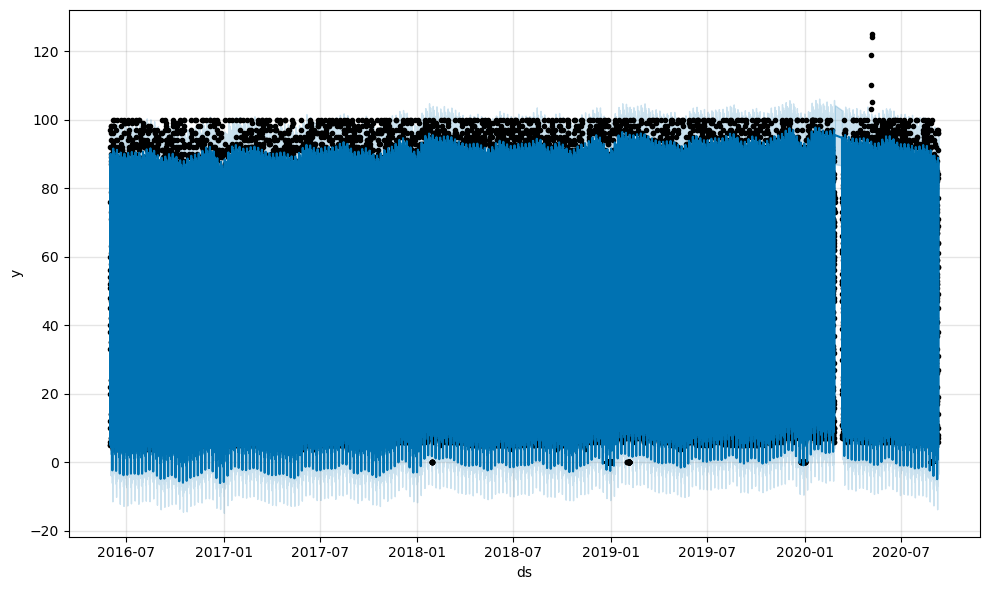

In [45]:
# Make a dataframe to hold predictions
future_df = model.make_future_dataframe(periods=24, freq='H')  # Predicting the next 24 hours

# Use the model to make predictions
forecast_df = model.predict(future_df)

# Plot the forecast
fig1 = model.plot(forecast_df)

C:\Users\jan\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\jan\anaconda3\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
C:\Users\jan\anaconda3\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

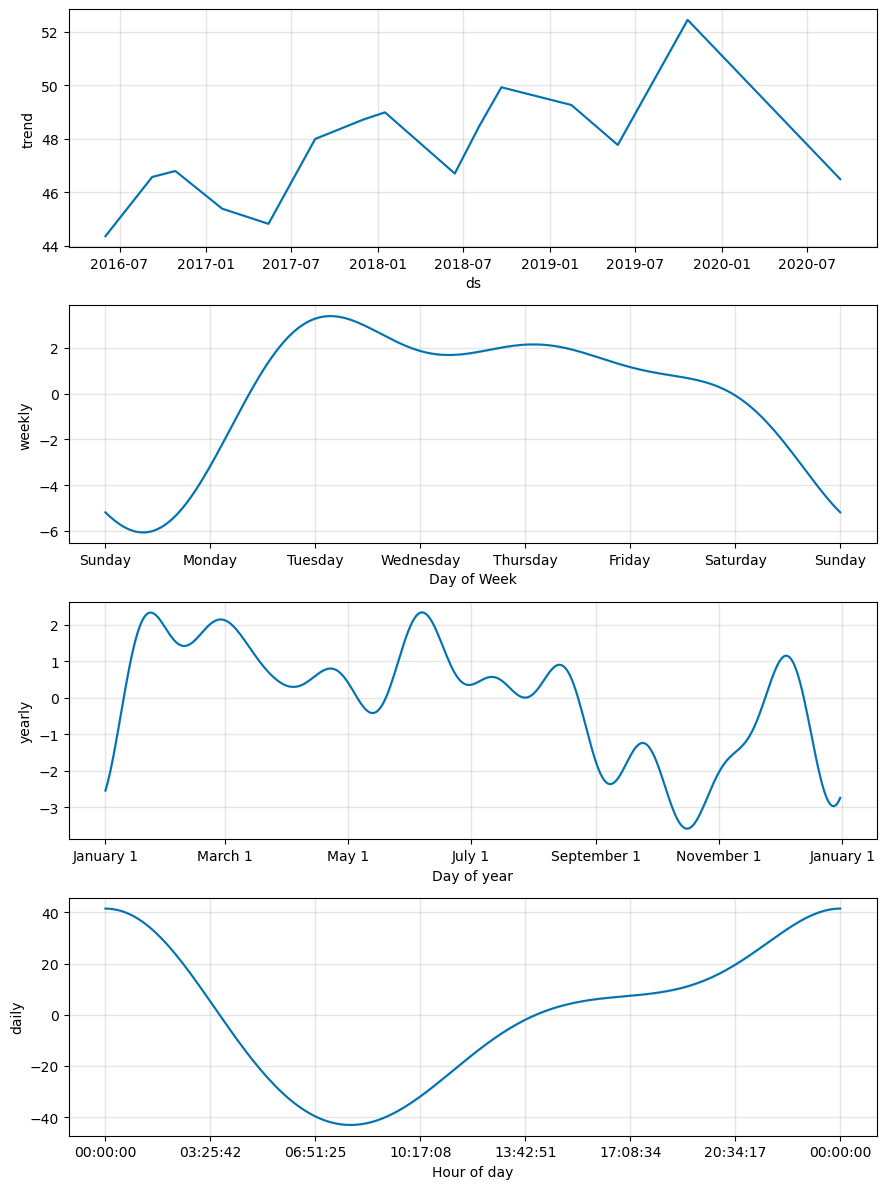

In [46]:
# Plot the components of the forecast
fig2 = model.plot_components(forecast_df)

# Load the daily sales data
sales_data_df = pd.read_csv('Resources/mercado_daily_revenue.csv', parse_dates=['date'])
sales_data_df.rename(columns={'date': 'ds', 'Daily Sales': 'y'}, inplace=True)

# Initialize and fit the Prophet model
sales_model = Prophet(daily_seasonality=True)
sales_model.fit(sales_data_df)

# Create a dataframe for future predictions covering the next quarter (roughly 90 days)
future_sales_df = sales_model.make_future_dataframe(periods=90)

# Predict future sales
forecast_sales_df = sales_model.predict(future_sales_df)

# Plot the forecast
fig1 = sales_model.plot(forecast_sales_df)

# Plot the components of the forecast (trends and seasonality)
fig2 = sales_model.plot_components(forecast_sales_df)

# Extract forecasted sales for the next quarter
next_quarter_forecast = forecast_sales_df.tail(90)

# Summarize the forecast
expected_sales = next_quarter_forecast['yhat'].sum()
best_case_sales = next_quarter_forecast['yhat_upper'].sum()
worst_case_sales = next_quarter_forecast['yhat_lower'].sum()

# Display forecast summary
display(HTML(f"""
<p><strong>Expected Sales for Next Quarter:</strong> {expected_sales:.2f}</p>
<p><strong>Best Case Scenario:</strong> {best_case_sales:.2f}</p>
<p><strong>Worst Case Scenario:</strong> {worst_case_sales:.2f}</p>
"""))
